In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

# Load BERDO
df = pd.read_csv('Building Emissions Reduction and Disclosure Ordinance (BERDO).csv', low_memory=False)
print(f'Shape: {df.shape}')
print(f'\nColumns:\n{list(df.columns)}')


Shape: (5579, 55)

Columns:
['_id', 'BERDO ID', 'Tax Parcel ID', 'Property Owner Name', 'Building Address', 'Building Address City', 'Building Address Zip  Code', 'Parcel Address', 'Parcel Address City', 'Parcel Address Zip Code', 'Reported Gross Floor Area (Sq Ft)', 'Reported Enclosed Parking Area (Sq Ft)', 'BERDO Emissions Gross Floor Area (Sq Ft)', 'Largest Property Type', 'All Property Types and GFAs', 'Total Site Energy Usage (kBtu)', 'Energy Star Score', 'Site EUI (Energy Use Intensity kBtu/ft2)', 'Natural Gas Usage (kBtu)', 'Natural Gas Emissions (kgCO2e)', 'Electricity Usage (kWh)', 'Electricity Emissions (kgCO2e)', 'Renewable System Electricity Usage Onsite (kBtu)', 'District Hot Water Usage (kBtu)', 'District Hot Water Emissions (kgCO2e)', 'District Chilled Water Usage (kBtu)', 'District Chilled Water Emissions (kgCO2e)', 'District Steam Usage (kBtu)', 'District Steam Emissions (kgCO2e)', 'Fuel Oil 1 Usage (kBtu)', 'Fuel Oil 1 Emissions (kgCO2e)', 'Fuel Oil 2 Usage (kBtu)', '

In [20]:
#  Check missing values for key columns 
key_cols = ['Largest Property Type', 'Building Address Zip  Code', 
            'Reporting Compliance Status', 'Reported Gross Floor Area (Sq Ft)',
            'Site EUI (Energy Use Intensity kBtu/ft2)', 
            'Estimated Total GHG Emissions (kgCO2e)', 'Energy Star Score']

print(' Missing Values (key columns)')
for col in key_cols:
    null_pct = df[col].isnull().sum() / len(df) * 100
    print(f'  {col}: {null_pct:.1f}%')

#  Property Type distribution 
print('\nLargest Property Type')
print(df['Largest Property Type'].value_counts())

#  Compliance Status 
print('\n Reporting Compliance Status')
print(df['Reporting Compliance Status'].value_counts())

#  Zip Code (top 10) 
print('\nTop 10 Zip Codes')
print(df['Building Address Zip  Code'].value_counts().head(10))

 Missing Values (key columns)
  Largest Property Type: 29.6%
  Building Address Zip  Code: 1.6%
  Reporting Compliance Status: 1.6%
  Reported Gross Floor Area (Sq Ft): 29.6%
  Site EUI (Energy Use Intensity kBtu/ft2): 34.1%
  Estimated Total GHG Emissions (kgCO2e): 32.9%
  Energy Star Score: 64.8%

Largest Property Type
Largest Property Type
Multifamily Housing                           2104
Office                                         455
College/University                             310
K-12 School                                    167
Hotel                                           66
                                              ... 
Other - Stadium                                  1
Single Family Home                               1
Zoo                                              1
Outpatient Rehabilitation/Physical Therapy       1
Race Track                                       1
Name: count, Length: 70, dtype: int64

 Reporting Compliance Status
Reporting Compliance Statu

Top 8 types cover 3230/5579 records (57.9%)

Representation:
  Multifamily Housing: 2104 (65.1%)
  Office: 455 (14.1%)
  College/University: 310 (9.6%)
  K-12 School: 167 (5.2%)
  Hotel: 66 (2.0%) ⚠️ UNDERREPRESENTED
  Laboratory: 50 (1.5%) ⚠️ UNDERREPRESENTED
  Worship Facility: 40 (1.2%) ⚠️ UNDERREPRESENTED
  Self-Storage Facility: 38 (1.2%) ⚠️ UNDERREPRESENTED


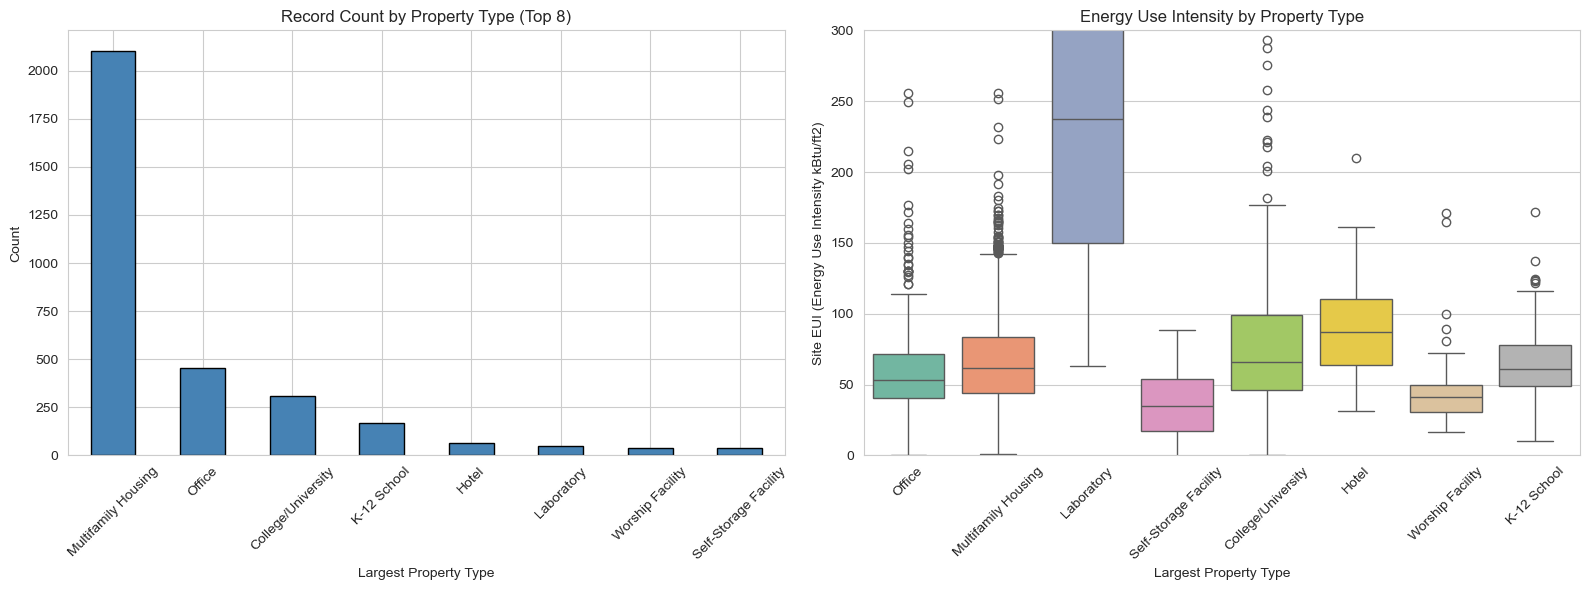

In [22]:
#  Convert numeric columns 
for col in ['Reported Gross Floor Area (Sq Ft)', 'Site EUI (Energy Use Intensity kBtu/ft2)',
            'Estimated Total GHG Emissions (kgCO2e)', 'Total Site Energy Usage (kBtu)']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

#  Focus on top 8 property types (enough data for statistical tests) 
top_types = df['Largest Property Type'].value_counts().head(8).index
df_top = df[df['Largest Property Type'].isin(top_types)].copy()

print(f'Top 8 types cover {len(df_top)}/{len(df)} records ({len(df_top)/len(df)*100:.1f}%)')
print(f'\nRepresentation:')
for t in top_types:
    count = (df_top['Largest Property Type'] == t).sum()
    pct = count / len(df_top) * 100
    flag = ' ⚠️ UNDERREPRESENTED' if pct < 5 else ''
    print(f'  {t}: {count} ({pct:.1f}%){flag}')

#  Visualization 
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

df_top['Largest Property Type'].value_counts().plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_title('Record Count by Property Type (Top 8)')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

sns.boxplot(data=df_top, x='Largest Property Type', 
            y='Site EUI (Energy Use Intensity kBtu/ft2)', ax=axes[1], palette='Set2')
axes[1].set_title('Energy Use Intensity by Property Type')
axes[1].set_ylim(0, 300)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [24]:
#  Kruskal-Wallis: Is EUI significantly different across property types? 
print(' Kruskal-Wallis H-Test: Site EUI by Property Type')
groups = [df_top[df_top['Largest Property Type'] == t]['Site EUI (Energy Use Intensity kBtu/ft2)'].dropna()
          for t in top_types]
# Only keep groups with enough data
groups = [g for g in groups if len(g) >= 5]

stat, p_value = stats.kruskal(*groups)
print(f'H-statistic: {stat:.4f}')
print(f'p-value:     {p_value:.6f}')
print(f'Significant (p < 0.05): {p_value < 0.05}')

#  Coefficient of Variation across group means 
group_means = df_top.groupby('Largest Property Type')['Site EUI (Energy Use Intensity kBtu/ft2)'].mean()
cv = group_means.std() / group_means.mean()
print(f'\nGroup means:')
print(group_means.sort_values(ascending=False).round(2))
print(f'\nCoefficient of Variation (CV): {cv:.4f}')
print('⚠️ HIGH DISPARITY (CV > 0.3)' if cv > 0.3 else '✓ Acceptable')

#  Compliance rate by property type 
print('\n Compliance Rate by Property Type')
compliance = df_top.groupby('Largest Property Type')['Reporting Compliance Status'].apply(
    lambda x: (x == 'in compliance').mean() * 100
).sort_values(ascending=False).round(1)
print(compliance)

gap = compliance.max() - compliance.min()
print(f'\nCompliance gap: {gap:.1f}%')
print(f'⚠️ SIGNIFICANT DISPARITY' if gap > 20 else '✓ Acceptable')

 Kruskal-Wallis H-Test: Site EUI by Property Type
H-statistic: 218.5005
p-value:     0.000000
Significant (p < 0.05): True

Group means:
Largest Property Type
Laboratory               233.25
Hotel                     89.63
College/University        86.05
Multifamily Housing       67.79
K-12 School               64.00
Office                    60.99
Self-Storage Facility     57.54
Worship Facility          50.19
Name: Site EUI (Energy Use Intensity kBtu/ft2), dtype: float64

Coefficient of Variation (CV): 0.6762
⚠️ HIGH DISPARITY (CV > 0.3)

 Compliance Rate by Property Type
Largest Property Type
College/University       95.8
Laboratory               94.0
Hotel                    93.9
K-12 School              93.4
Worship Facility         92.5
Multifamily Housing      91.9
Office                   90.1
Self-Storage Facility    68.4
Name: Reporting Compliance Status, dtype: float64

Compliance gap: 27.4%
⚠️ SIGNIFICANT DISPARITY


Neighborhood Distribution
  Allston/Brighton: 13.1%
  Back Bay/Fenway: 11.6%
  Dorchester: 11.4%
  South Boston: 5.9%
  Roxbury: 5.1%
  East Boston: 4.8%
  Back Bay/South End: 4.8%
  Jamaica Plain: 4.8%
  South End: 4.4%
  Mattapan: 4.2%
  Other: 3.9%
  Charlestown: 3.8%
  Hyde Park: 3.7%
  West End: 2.8% ⚠️ UNDERREPRESENTED
  North End: 2.7% ⚠️ UNDERREPRESENTED
  West Roxbury: 2.5% ⚠️ UNDERREPRESENTED
  Roslindale: 2.5% ⚠️ UNDERREPRESENTED
  Chinatown/Downtown: 2.4% ⚠️ UNDERREPRESENTED
  Mission Hill: 2.1% ⚠️ UNDERREPRESENTED
  Seaport: 2.0% ⚠️ UNDERREPRESENTED
  Beacon Hill: 1.6% ⚠️ UNDERREPRESENTED


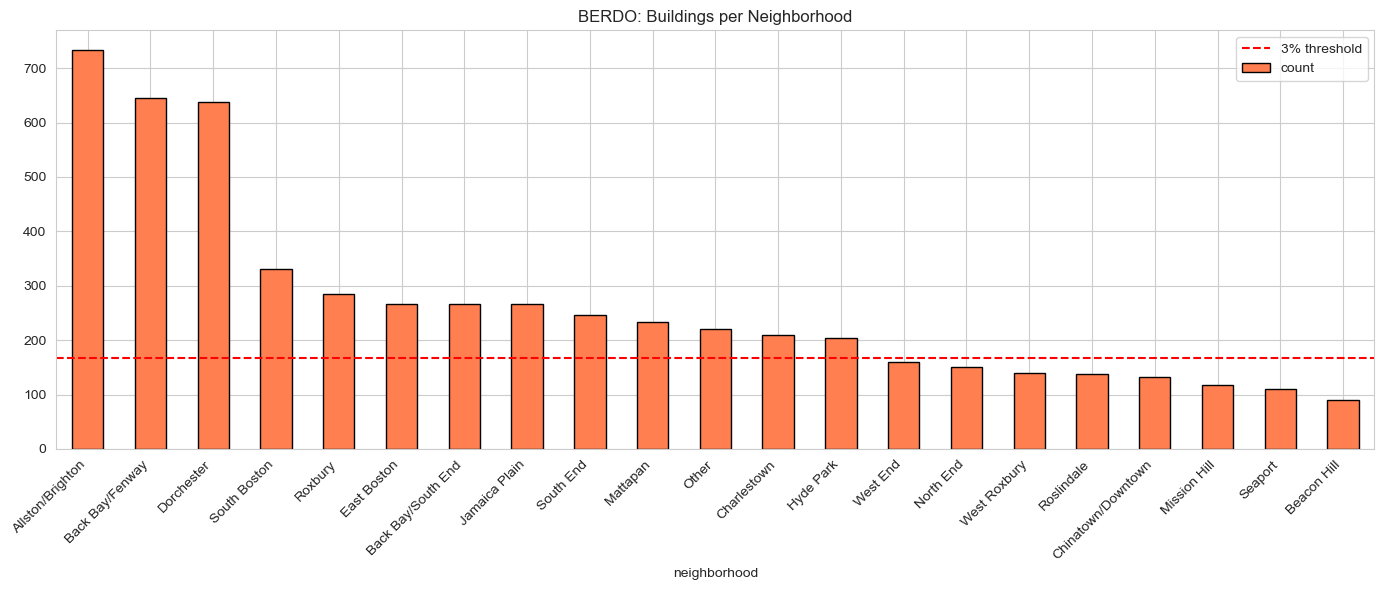

In [26]:
#  Map zip codes to neighborhoods 
zip_to_nbhd = {
    2134: 'Allston/Brighton', 2135: 'Allston/Brighton', 2115: 'Back Bay/Fenway',
    2215: 'Back Bay/Fenway', 2116: 'Back Bay/South End', 2118: 'South End',
    2119: 'Roxbury', 2120: 'Mission Hill', 2121: 'Dorchester', 2122: 'Dorchester',
    2124: 'Dorchester', 2125: 'Dorchester', 2126: 'Mattapan', 2127: 'South Boston',
    2128: 'East Boston', 2129: 'Charlestown', 2130: 'Jamaica Plain',
    2131: 'Roslindale', 2132: 'West Roxbury', 2136: 'Hyde Park',
    2210: 'Seaport', 2111: 'Chinatown/Downtown', 2108: 'Beacon Hill',
    2109: 'North End', 2113: 'North End', 2114: 'West End',
}

df['zip_num'] = pd.to_numeric(df['Building Address Zip  Code'], errors='coerce').astype('Int64')
df['neighborhood'] = df['zip_num'].map(zip_to_nbhd).fillna('Other')

#  Neighborhood distribution 
print('Neighborhood Distribution')
nbhd_pct = df['neighborhood'].value_counts(normalize=True) * 100
for n, p in nbhd_pct.items():
    flag = ' ⚠️ UNDERREPRESENTED' if p < 3 else ''
    print(f'  {n}: {p:.1f}%{flag}')

#  Visualization 
fig, ax = plt.subplots(figsize=(14, 6))
df['neighborhood'].value_counts().plot(kind='bar', ax=ax, color='coral', edgecolor='black')
ax.axhline(y=len(df)*0.03, color='red', linestyle='--', label='3% threshold')
ax.set_title('BERDO: Buildings per Neighborhood')
ax.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [28]:
# MITIGATION 1: Oversampling underrepresented neighborhoods
print('Mitigation 1: Oversampling Underrepresented Neighborhoods')
min_pct = 3.0
target_count = int(len(df) * min_pct / 100)  # minimum records per neighborhood

df_mitigated = df.copy()
for nbhd, group in df.groupby('neighborhood'):
    pct = len(group) / len(df) * 100
    if pct < min_pct and len(group) > 0:
        n_needed = target_count - len(group)
        if n_needed > 0:
            oversampled = group.sample(n=n_needed, replace=True, random_state=42)
            df_mitigated = pd.concat([df_mitigated, oversampled], ignore_index=True)
            print(f'  {nbhd}: {len(group)} → {len(group)+n_needed}')

print(f'\nOriginal: {len(df)} rows → Mitigated: {len(df_mitigated)} rows')

# MITIGATION 2: Within-group normalization
print('\n Mitigation 2: Z-Score Normalization of EUI by Property Type')
df_top['eui_normalized'] = df_top.groupby('Largest Property Type')[
    'Site EUI (Energy Use Intensity kBtu/ft2)'].transform(
    lambda x: (x - x.mean()) / x.std() if x.std() > 0 else 0
)

print('Before (raw EUI means by type):')
print(df_top.groupby('Largest Property Type')['Site EUI (Energy Use Intensity kBtu/ft2)'].mean().round(1))
print('\nAfter (normalized means — should all be ~0):')
print(df_top.groupby('Largest Property Type')['eui_normalized'].mean().round(4))
print('✓ Cross-type disparity removed for fair comparison')

# MITIGATION 3: Stratified train/val/test split
print('\n Mitigation 3: Stratified Splitting')
# Create a combined stratification column
df_valid = df_top.dropna(subset=['Largest Property Type'])
strat_col = df_valid['Largest Property Type'].where(
    df_valid['Largest Property Type'].isin(top_types), 'Other'
)

from sklearn.model_selection import train_test_split

train, temp = train_test_split(df_valid, test_size=0.30, random_state=42, stratify=strat_col)
strat_temp = temp['Largest Property Type'].where(temp['Largest Property Type'].isin(top_types), 'Other')
val, test = train_test_split(temp, test_size=0.50, random_state=42, stratify=strat_temp)

print(f'Train: {len(train)} (70%) | Val: {len(val)} (15%) | Test: {len(test)} (15%)')

# Verify proportions are preserved
print('\nMultifamily Housing % across splits:')
for name, split in [('Full', df_valid), ('Train', train), ('Val', val), ('Test', test)]:
    pct = (split['Largest Property Type'] == 'Multifamily Housing').mean() * 100
    print(f'  {name}: {pct:.1f}%')
print('✓ Proportions preserved across splits')

Mitigation 1: Oversampling Underrepresented Neighborhoods
  Beacon Hill: 90 → 167
  Chinatown/Downtown: 133 → 167
  Mission Hill: 117 → 167
  North End: 150 → 167
  Roslindale: 137 → 167
  Seaport: 111 → 167
  West End: 159 → 167
  West Roxbury: 139 → 167

Original: 5579 rows → Mitigated: 5879 rows

 Mitigation 2: Z-Score Normalization of EUI by Property Type
Before (raw EUI means by type):
Largest Property Type
College/University        86.1
Hotel                     89.6
K-12 School               64.0
Laboratory               233.3
Multifamily Housing       67.8
Office                    61.0
Self-Storage Facility     57.5
Worship Facility          50.2
Name: Site EUI (Energy Use Intensity kBtu/ft2), dtype: float64

After (normalized means — should all be ~0):
Largest Property Type
College/University      -0.0
Hotel                   -0.0
K-12 School             -0.0
Laboratory              -0.0
Multifamily Housing     -0.0
Office                   0.0
Self-Storage Facility    0.0
Wo